In [35]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import json
import torchvision.transforms.v2 as transforms
import time

from tqdm import tqdm
from models import TinyVGG
from PIL import Image
from pathlib import Path
from torch.utils.data import DataLoader
from torch import nn
from torchvision import datasets
from torchvision.transforms.v2 import functional as F
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

print(f"[INFO] torch version {torch.__version__}")
print(f"[INFO] torchvision version {torchvision.__version__}")

[INFO] torch version 2.0.0+cu117
[INFO] torchvision version 0.15.1+cu117


In [2]:
def Category_reader(path: str):
    with open(path, 'r') as f:
        text = json.load(f)
    categories = text['categories']
    class_names = {}
    for category in categories:
        class_names[category['id']] = category['name']
    return class_names

In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
train_image_path = Path("/home/famousdeer/Desktop/Praca magisterska/Program/data/Images/train2017")
train_ann_path = Path("/home/famousdeer/Desktop/Praca magisterska/Program/data/annotations/instances_train2017.json")
val_image_path = Path("/home/famousdeer/Desktop/Praca magisterska/Program/data/Images/val2017")
val_ann_path = Path("/home/famousdeer/Desktop/Praca magisterska/Program/data/annotations/instances_val2017.json")

In [5]:
class_names = Category_reader(val_ann_path)
class_names

{1: 'person',
 2: 'bicycle',
 3: 'car',
 4: 'motorcycle',
 5: 'airplane',
 6: 'bus',
 7: 'train',
 8: 'truck',
 9: 'boat',
 10: 'traffic light',
 11: 'fire hydrant',
 13: 'stop sign',
 14: 'parking meter',
 15: 'bench',
 16: 'bird',
 17: 'cat',
 18: 'dog',
 19: 'horse',
 20: 'sheep',
 21: 'cow',
 22: 'elephant',
 23: 'bear',
 24: 'zebra',
 25: 'giraffe',
 27: 'backpack',
 28: 'umbrella',
 31: 'handbag',
 32: 'tie',
 33: 'suitcase',
 34: 'frisbee',
 35: 'skis',
 36: 'snowboard',
 37: 'sports ball',
 38: 'kite',
 39: 'baseball bat',
 40: 'baseball glove',
 41: 'skateboard',
 42: 'surfboard',
 43: 'tennis racket',
 44: 'bottle',
 46: 'wine glass',
 47: 'cup',
 48: 'fork',
 49: 'knife',
 50: 'spoon',
 51: 'bowl',
 52: 'banana',
 53: 'apple',
 54: 'sandwich',
 55: 'orange',
 56: 'broccoli',
 57: 'carrot',
 58: 'hot dog',
 59: 'pizza',
 60: 'donut',
 61: 'cake',
 62: 'chair',
 63: 'couch',
 64: 'potted plant',
 65: 'bed',
 67: 'dining table',
 70: 'toilet',
 72: 'tv',
 73: 'laptop',
 74: 'mo

In [6]:
# Creating image size base on tabel 3 in the ViT paper
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 4

In [7]:
# Create transform pipeline manually
transform = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()
                                ])

/home/famousdeer/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [20]:
train_dataset = datasets.CocoDetection(str(train_image_path), str(train_ann_path), transforms=transform)
val_dataset = datasets.CocoDetection(str(val_image_path), str(val_ann_path), transforms=transform)


loading annotations into memory...
Done (t=13.94s)
creating index...
index created!
loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


In [21]:
# Show some examples
def show(sample):
    image, target = sample
    if isinstance(image, Image.Image):
        image = F.to_image_tensor(image)
    image = F.convert_dtype(image, torch.uint8)
    annotated_image = draw_bounding_boxes(image, target["boxes"], width=3) #draw_segmentation_masks(image, target['masks'].bool(), alpha=0.6)

    fig, ax = plt.subplots()
    ax.imshow(annotated_image.permute(1, 2, 0).numpy())
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    fig.tight_layout()


In [22]:
dataset = datasets.wrap_dataset_for_transforms_v2(val_dataset)

sample = dataset[0]
image, target = sample
print(type(image))
print(type(target), list(target.keys()))
print(type(target["boxes"]), type(target["masks"]), type(target["labels"]))

<class 'torch.Tensor'>
<class 'dict'> ['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id', 'boxes', 'masks', 'labels']
<class 'torchvision.datapoints._bounding_box.BoundingBox'> <class 'torchvision.datapoints._mask.Mask'> <class 'torch.Tensor'>


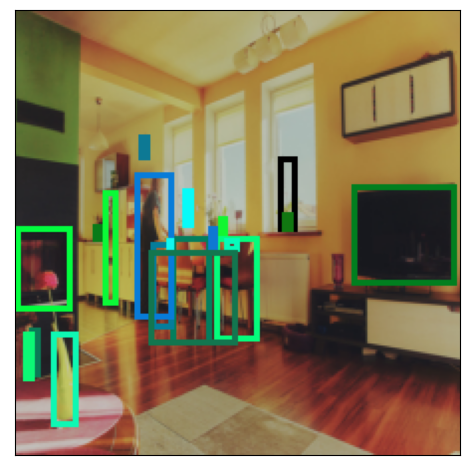

In [23]:
show(sample)

In [24]:
train_loader = DataLoader(
                            dataset=train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=NUM_WORKERS,
                            pin_memory=True
                            )
val_loader = DataLoader(
                            dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            num_workers=NUM_WORKERS,
                            pin_memory=True
                            )

In [25]:
train_loader.dataset

Dataset CocoDetection
    Number of datapoints: 118287
    Root location: /home/famousdeer/Desktop/Praca magisterska/Program/data/Images/train2017
    Compose(
      Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=warn)
      RandomHorizontalFlip(p=0.5)
      ToTensor()
)

In [26]:
model_1 = TinyVGG(input_shape=3, hidden_units=32).to(device)
model_1

TinyVGG(
  (convblockv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convblockv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convblockv3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convblockv4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mo

In [28]:
# LOSS FUNCTIONS
idx_p =[0]
idx_bb = [1, 2, 3, 4]
idx_cls = [i for i in range(5, 95)]


def loss_bb(y_true, y_pred):
    y_true = torch.index_select(y_true, -1, torch.tensor(idx_bb))
    y_pred = torch.index_select(y_pred, -1, torch.tensor(idx_bb))

    loss_fn = nn.MSELoss()
    loss = loss_fn(y_true, y_pred, reduction='none')

    return torch.mean(loss[loss > 0.0])

def loss_p(y_true, y_pred):
    y_true = torch.index_select(y_true, idx_p, axis=-1)
    y_pred = torch.index_select(y_true, idx_p, axix=-1)

    loss_fn = nn.BCELoss()
    loss = loss_fn(y_true, y_pred)
    
    return torch.sum(loss)


def loss_cls(y_true, y_pred):
    y_true = torch.index_select(y_true, idx_cls, axis=-1)
    y_pred = torch.index_select(y_true, idx_cls, axis=-1)

    loss_fn = nn.BCELoss()
    loss = loss_fn(y_true, y_pred)

    return torch.sum(loss)


def loss_fn(y_true, y_pred):
    return loss_bb(y_true, y_pred) + loss_p(y_true, y_pred) +loss_cls(y_true, y_pred)

optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.003)